<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/08a-analyze_recommendations.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Analyze Recommendations

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

### Outline

- Read current data
- Interact features with market volatility
- Load saved model
- Make predictions

## 1. Preliminaries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from joblib import load 
from urllib.request import urlopen

### Read the model

In [2]:
url = "https://www.dropbox.com/scl/fi/kssvcsgze16p36dwjyiaw/forest_ver2.joblib?rlkey=76hbmsqnecyv96qsmi39fwrr8&dl=1"
file = urlopen(url)
forest = load(file)

### Define features

In [3]:
features = [
    "marketcap", 
    "pb", 
    "mom", 
    "volume", 
    "volatility", 
    "roe", 
    "accruals", 
    "agr"
]
features.sort()
features_final = features + [x + "_vol" for x in features]

### Read predictions and characteristics

In [4]:
df = pd.read_excel("https://www.dropbox.com/scl/fi/g8ymjrhppr9xhcoaxjsgg/predict-2023-11-13.xlsx?rlkey=t2ywdf8yc43c4z9uymjaepnev&dl=1")
mktvol = df.loc[0, "mktvol"]

### Calculate medians of characteristics

In [5]:
medians = df[features].median()
medians = pd.DataFrame(medians).T
medians

,accruals,agr,marketcap,mom,pb,roe,volatility,volume
0,-0.085859,0.005876,782.7,-0.097035,1.4,0.062268,0.054299,220361.6


### Function for varying one characteristic at a time

In [34]:
def predict1(char):
    data = medians.copy()
    grid = np.linspace(
        df[char].quantile(0.005), 
        df[char].quantile(0.995), 
        100
    )
    predictions = []
    for x in grid:
        data[char] = x
        for f in features:
            data[f+"_vol"] = data[f]*mktvol
        prediction = forest.predict(X=data)
        predictions.append(prediction)
    return grid, predictions

### Function for varying two characteristics at a time

In [35]:
def predict2(char1, char2):
    data = medians.copy()
    grid1 = np.linspace(
        df[char1].quantile(0.005), 
        df[char1].quantile(0.995), 
        20
    )
    grid2 = np.linspace(
        df[char2].quantile(0.01), 
        df[char2].quantile(0.99), 
        20
    )
    grid1, grid2 = np.meshgrid(grid1, grid2)
    predictions = np.empty(grid1.shape)
    for i in range(20):
        for j in range(20):
            data[char1] = grid1[i, j]
            data[char2] = grid2[i, j]
            for f in features:
                data[f+"_vol"] = data[f]*mktvol
            predictions[i, j] = forest.predict(data)
    return grid1, grid2, predictions

### Function for varying one characteristic and market volatility

In [36]:
def predict3(char):
    data = medians.copy()
    grid1 = np.linspace(
        df[char].quantile(0.005), 
        df[char].quantile(0.995), 
        20
    )
    grid2 = np.linspace(
        0.5*mktvol, 
        1.5*mktvol,
        20
    )
    grid1, grid2 = np.meshgrid(grid1, grid2)
    predictions = np.empty(grid1.shape)
    for i in range(20):
        for j in range(20):
            data[char] = grid1[i, j]
            for f in features:
                data[f+"_vol"] = data[f]*grid2[i, j]
            predictions[i, j] = forest.predict(data)
    return grid1, grid2, predictions

## 2. Interpret model

### 2a. Feature importances

In [37]:
importances = pd.Series(forest.feature_importances_, index=features_final)
importances.sort_values(ascending=False).round(3)

roe               0.472
volatility        0.107
accruals_vol      0.069
volatility_vol    0.058
marketcap_vol     0.048
accruals          0.040
marketcap         0.031
volume            0.027
mom_vol           0.027
roe_vol           0.026
mom               0.025
agr               0.017
agr_vol           0.017
volume_vol        0.017
pb_vol            0.012
pb                0.009
dtype: float64

### 2b. Vary one characteristic at a time and plot

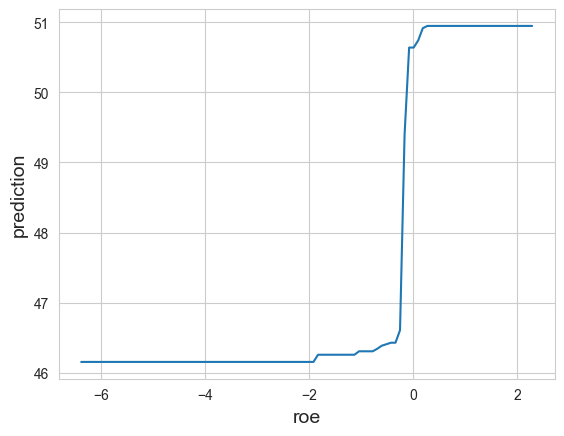

In [38]:
char = "roe"

grid, predictions = predict1(char)
plt.plot(grid, predictions)
plt.xlabel(char,  fontdict={"size": 14})
plt.ylabel("prediction",  fontdict={"size": 14})
plt.show()

### 2c. Vary two characteristics at a time and plot

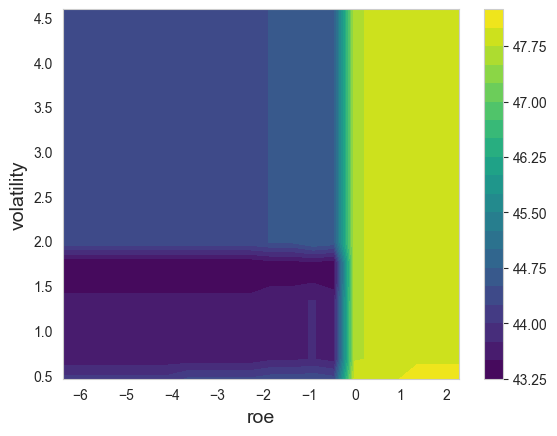

In [39]:
char1 = "roe"  
char2 = "volatility"  

grid1, grid2, predictions = predict2(char1, char2)
contour = plt.contourf(grid1, grid2, predictions, 20, cmap="viridis")
cbar = plt.colorbar(contour)
plt.xlabel(char1, fontdict={"size": 14})
plt.ylabel(char2, fontdict={"size": 14})
plt.show()

### 2d. Vary one characteristic and market volatility

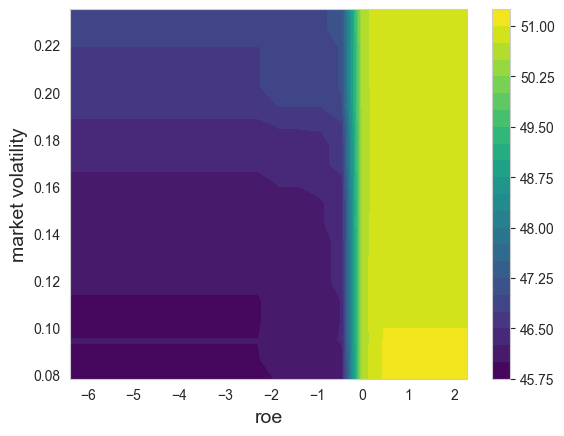

In [40]:
char = "roe"  

grid1, grid2, predictions = predict3(char)
contour = plt.contourf(grid1, grid2, predictions, 20, cmap="viridis")
cbar = plt.colorbar(contour)
plt.xlabel(char, fontdict={"size": 14})
plt.ylabel("market volatility", fontdict={"size": 14})
plt.show()

### 2e. Linear regression

In [41]:
import statsmodels.formula.api as smf

for f in features:
    df[f] = df[f] / df[f].std()

string = "predict ~ " + " + ".join(features)
model = smf.ols(string, data=df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                predict   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     234.5
Date:                Tue, 14 Nov 2023   Prob (F-statistic):          4.25e-270
Time:                        15:25:57   Log-Likelihood:                -2687.7
No. Observations:                1753   AIC:                             5393.
Df Residuals:                    1744   BIC:                             5443.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.8577      0.064    797.304      0.000      50.733      50.983
accruals      -0.3979      0.049     -8.148      0.000      -0.494      -0.302
agr           -0.0157      0.027     -0.580      0.562      -0.069       0.037
marketcap      0.2282      0.029      7.995      0.000       0.172       0.284
mom            0.2899      0.031      9.473      0.000       0.230       0.350
pb            -0.1762      0.047     -3.770      0.000      -0.268      -0.085
roe            0.7124      0.032     22.082      0.000       0.649       0.776
volatility    -0.7569      0.033    -22.673      0.000      -0.822      -0.691
volume        -0.0150      0.029     -0.519      0.604      -0.072       0.042
==============================================================================
Omnibus:                      774.932   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8567.503
Skew:                          -1.770   Prob(JB):                         0.00
Kurtosis:                      13.236   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""